C:\Users\deban\AppData\Local\Temp\ipykernel_9888\2615935374.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y0 = torch.tensor(y0)


Iter    0 | Loss 5.206787
Iter  200 | Loss 0.337134
Iter  400 | Loss 0.309200
Iter  600 | Loss 0.292308
Iter  800 | Loss 0.281545
Iter 1000 | Loss 0.270944
Iter 1200 | Loss 0.231746
Iter 1400 | Loss 0.011733
Iter 1600 | Loss 0.002419
Iter 1800 | Loss 0.001178


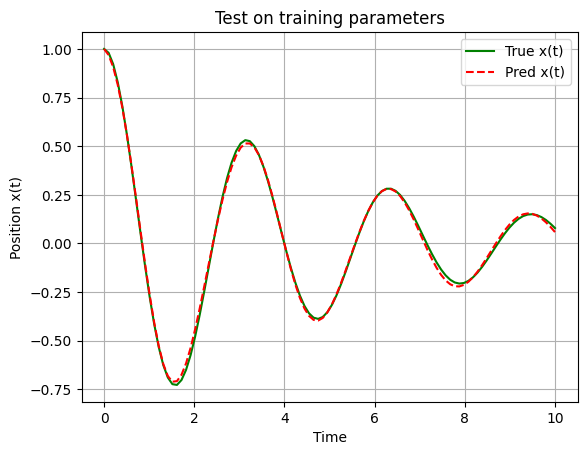

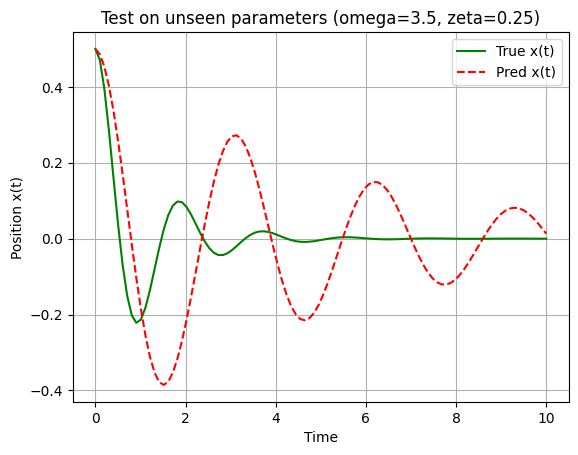

In [6]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchdiffeq import odeint

# Fix randomness for reproducibility
torch.manual_seed(0)

# True dynamics of damped harmonic oscillator
def damped_oscillator(t, y, omega=2.0, zeta=0.1):
    x, v = y[..., 0], y[..., 1]
    dxdt = v
    dvdt = -2 * zeta * omega * v - omega**2 * x
    return torch.stack([dxdt, dvdt], dim=-1)

# Generate synthetic data
def generate_data(omega, zeta, y0, t):
    y0 = torch.tensor(y0)
    with torch.no_grad():
        y = odeint(lambda t, y: damped_oscillator(t, y, omega, zeta), y0, t)
    return y

# Training data
t = torch.linspace(0, 10, 100)
omega_train, zeta_train = 2.0, 0.1
y0_train = torch.tensor([1.0, 0.0])
true_y = generate_data(omega_train, zeta_train, y0_train, t)

# Define neural ODE model
class ODEFunc(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 2),
        )
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)

    def forward(self, t, y):
        return self.net(y)

# Training loop
def train(model, y0, t, true_y, n_iters=2000, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    for itr in range(n_iters):
        pred_y = odeint(model, y0, t)
        loss = loss_fn(pred_y, true_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if itr % 200 == 0:
            print(f"Iter {itr:4d} | Loss {loss.item():.6f}")
    return model

# Train model
model = ODEFunc()
model = train(model, y0_train, t, true_y)

# ---- Evaluation ----

@torch.no_grad()
def plot_prediction(model, y0, t, true_y, title):
    pred_y = odeint(model, y0, t)
    plt.plot(t, true_y[:, 0], 'g-', label='True x(t)')
    plt.plot(t, pred_y[:, 0], 'r--', label='Pred x(t)')
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Position x(t)")
    plt.legend()
    plt.grid(True)
    plt.show()

# 1. Test on training parameters
plot_prediction(model, y0_train, t, true_y, "Test on training parameters")

# 2. Test on unseen parameters
omega_new, zeta_new = 3.5, 0.25
y0_new = torch.tensor([0.5, 0.0])
true_y_new = generate_data(omega_new, zeta_new, y0_new, t)
plot_prediction(model, y0_new, t, true_y_new, "Test on unseen parameters (omega=3.5, zeta=0.25)")
